In [1]:
# !yes | add-apt-repository ppa:mscore-ubuntu/mscore3-stable &> /dev/null
# !apt update &> /dev/null
# !apt install musescore3 &> /dev/null
# !pip install piano_fingering


In [39]:
import music21
import random
import pandas as pd

from music21 import pitch
from music21 import note, chord, articulations
from piano_fingering import computeFingering
from pprint import pprint, pformat
from fractions import Fraction

import os
import glob
import re
import csv
import math
import time
import numpy as np
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from typing import List

music_score_path = 'C:/Program Files/MuseScore 4/bin/MuseScore4.exe'
music21.environment.set('musescoreDirectPNGPath', music_score_path)

## Pitch Utilities


In [3]:
def extract_pitch_info(pitch):
    """
    Returns white key index and black key flag from pitch string.

    The white key index is centered around C4 (i.e., C4 → 0, C5 → 7, C3 → -7).

    Args:
        pitch (str): Note like "C4", "D#5", "Bb3".

    Returns:
        tuple: (white_key_val, black_key), where black_key is 1 for sharp/flat, 0 otherwise.

    """

    
    # Extract the base note and octave
    base_note = pitch[0]  # First character (e.g., "C", "D")
    octave = 4  # Default octave is 4 (octave start from middle C)
    
    note_val = {"C": 0, "D": 1, "E": 2, "F": 3, "G": 4, "A": 5, "B": 6}
    
    # Is the key a black key right next to the base note? (e.g., C#4, D#4)
    black_key = 0 # Default is white key

    # To tuple that split white/black keys, for allowing the black_key to reduce the span needed 
    # Note: Minus 4 to center around C4 (Middle c); Times 7 to span octaves (7 semitones)
    if pitch[1].isdigit(): # No sharp/flat like "C4"
        note_val[base_note] += (int(pitch[1]) - 4) * 7
    elif pitch[1] == "#": # Sharp(1 semitone up) like "C#4
        black_key = 1
        note_val[base_note] += (int(pitch[2]) - 4) * 7
    elif pitch[1] in ["b", "-"]: # Flat(1 semitone down) like "Cb4"
        black_key = 1

    return (note_val[base_note], black_key)

In [4]:
def get_white_black_diff(pitch1, pitch2):
    """
    Calculate the white-key distance between two pitches.
    
    Args:
        pitch1, pitch2: Note pitch in the format of "C4", "D#5", etc.

    Returns:
        int: Semitone distance between two pitches
    """
    
    a = extract_pitch_info(pitch1) 
    b =  extract_pitch_info(pitch2)
    return abs(a[0] - b[0]), a[1] + b[1] 

In [5]:
def pass_bounds(notes):
    """
    Checks if any note in the list is out of the allowed MIDI range.
    """
    
    pass_range = False
    for n in notes:
        if not (n == 0 or (21 <= n < 108)):
            pass_range = True
    return pass_range


def interval_symmetry(piece, interval):
    """
    Generates symmetrical piece by applying interval shifts across multiple octaves.
    
    Args:
        piece (PianoPiece): The original piano piece object.
        interval (int): The interval (in semitones) to use for symmetry transposition.

    Returns:
        list of PianoPiece: List of transposed, symmetrical versions of the input piece.
    """
    
    pieces = []
    octaves = [-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    for octave in octaves:
        new_notes = [(n + (octave * interval)) if n != 0 else 0 for n in piece.notes]
        if not pass_bounds(new_notes):
            pieces.append(PianoPiece(new_notes, 
                                     piece.fingers, 
                                     piece.intervals, 
                                     piece.accidentals, 
                                     piece.ids, 
                                     
                                     piece.durations,
                                     piece.onset,
                                     piece.offset,

                                     piece.is_3_chord,
                                     piece.is_4_chord,
                                     piece.is_5_chord,
                                     piece.chord_tonic,
                                     piece.chord_sixth,
                                     piece.chord_second_inversion,
                                     
                                     piece.white_diff,
                                     piece.black_diff,
                                     piece.file_name))

    return pieces


## Chord Detection and Annotation

In [6]:
def detect_triad_type(notes):
    """
    Determines the type of chord based on a list of three note names.

    Args:
        notes (list of int): List of midi values.

    Returns:
        str: One of "tonic", "sixth", "second_inversion", or "unknown".
    """
    
    try:
        midi_notes = sorted([pitch.Pitch(n).midi for n in notes])
        intervals = [midi_notes[i] - midi_notes[0] for i in range(1, 3)]
        structure = (0, *intervals)

        if structure in [(0, 4, 7), (0, 3, 7)]:
            return "chord_tonic"
        elif structure in [(0, 3, 8), (0, 4, 9)]:
            return "chord_sixth"
        elif structure in [(0, 5, 9), (0, 5, 8)]:
            return "chord_second_inversion"
        else:
            return "unknown"
    except:
        return "unknown"


In [7]:

def mark_chords_with_type(df):
    """
    Adds one-hot encoded columns indicating chord type for triads.
    Also adds binary flags: is_3_chord, is_4_chord, is_5_chord.

    Args:
        df: DataFrame with a piano piece.

    Returns:
        Updated DataFrame with new one-hot encoded columns and chord size flags.
    """
    
    group_counts = df.groupby(["Onset", "Offset"]).size().reset_index(name="count")
    chord_groups = group_counts[group_counts["count"] >= 3][["Onset", "Offset", "count"]]

    df = df.merge(chord_groups.assign(is_chord=1), on=["Onset", "Offset"], how="left")
    df["is_chord"] = df["is_chord"].fillna(0).astype(int)
    df["count"] = df["count"].fillna(0).astype(int)

    df["chord_type"] = "none"

    for (onset, offset), group_df in df.groupby(["Onset", "Offset"]):
        if len(group_df) == 3:
            pitches = group_df["PitchName"].tolist()  
            chord_type = detect_triad_type(pitches)
            df.loc[(df["Onset"] == onset) & (df["Offset"] == offset), "chord_type"] = chord_type

    df["chord_type"] = df["chord_type"].replace("none", "unknown")

    dummies = pd.get_dummies(df["chord_type"], dtype='int')
    for i in dummies.columns:
        df[i] = dummies[i]

    df["is_3_chord"] = (df["count"] == 3).astype(int)
    df["is_4_chord"] = (df["count"] == 4).astype(int)
    df["is_5_chord"] = (df["count"] == 5).astype(int)
    
    # dropping unnecessary columns
    for i in ["count", "chord_type", "unknown", "is_chord"]:
        if i in df.columns:
            df = df.drop(i, axis=1)


    return df

In [8]:
def reorganize_fingers(df, hand="right"):
    """
    Reorganizes pitch data for chords or intervals.

    For each chord, the notes (and its rows) are sorted in ascending order.
    Example: Given a chord G4, E4, and C4 is reordered as C4, E4, G4.
    """

    df = df.copy()
    df["PitchPs"] = [pitch.Pitch(p).ps for p in df["PitchName"]]

    sorted_df = df.sort_values(by=["Onset", "PitchPs"])
    sorted_df["ID"] = range(len(sorted_df))
    sorted_df = sorted_df.drop(columns=["PitchPs"])
    
    return sorted_df


## Piano piece utils

In [9]:
class PianoPiece:
    """
    A data structure representing a piano piece with associated musical and fingering information.

    Attributes:
        notes : MIDI values representing the notes in the piece.
        fingers : Finger numbers corresponding to each note.
        intervals : Interval distances between consecutive notes.
        accidentals : Accidentals (sharps, flats, naturals) for each note.
        ids : Unique identifiers for each note or event.
        durations : Durations for each note in seconds.
        onset : Onset times (in seconds) for each note.
        offset : Offset times (in seconds) for each note.

        white_diff : Movement in terms of white keys between notes.
        black_diff : Movement in terms of black keys between notes.

        chords : Whether the note belongs to a chord.
        chord_tonic : Whether the note is in the root (tonic) chord.
        chord_sixth : Whether the note is in a sixth chord.
        chord_second_inversion : Whether the note is in a second inversion chord.

        file_name : Name of the file from which the data was derived.
    """

    def __init__(
        self,
        notes = None, fingers = None, intervals = None,
        accidentals = None, ids = None,
        durations = None, onset = None, offset = None,
        is_3_chord = None, is_4_chord = None, is_5_chord = None,
        chord_tonic = None, chord_sixth = None, chord_second_inversion = None,
        white_diff = None, black_diff = None,
        file_name: str = ""
    ):
        self.notes = notes
        self.fingers = fingers
        self.intervals = intervals
        self.accidentals = accidentals
        self.ids = ids
        self.durations = durations
        self.onset = onset
        self.offset = offset

        self.white_diff = white_diff
        self.black_diff = black_diff

        self.is_3_chord = is_3_chord
        self.is_4_chord = is_4_chord
        self.is_5_chord = is_5_chord
        self.chord_tonic = chord_tonic
        self.chord_sixth = chord_sixth
        self.chord_second_inversion = chord_second_inversion

        self.file_name = file_name

    def get_features(self, input_features):
        """Returns selected features in aligned format for model input."""
    
        feature_map = {
            "fingers": self.fingers[:-1],
            "notes": self.notes[:-1],
            "intervals": self.intervals,
            
            "accidentals_current": self.accidentals[:-1],
            "accidentals_next": self.accidentals[1:],
            "white_diff": self.white_diff[:-1],
            "black_diff": self.black_diff[:-1],
            # "chords": self.chords[:-1],
            
            "is_3_chord": self.is_3_chord[:-1],
            "is_4_chord": self.is_4_chord[:-1],
            "is_5_chord": self.is_5_chord[:-1],
            "chord_tonic": self.chord_tonic[:-1],
            "chord_sixth": self.chord_sixth[:-1],
            "chord_second_inversion": self.chord_second_inversion[:-1],
        }
        
        # Detect invalid features
        invalid_features = [name for name in input_features if name not in feature_map]
        if invalid_features:
            raise ValueError(f"The following input features are invalid: {invalid_features}")
    
        selected = [feature_map[name] for name in input_features]
    
        if not selected:
            raise ValueError("No valid features provided for model input.")
    
        return [list(x) for x in zip(*selected)]


In [10]:
def load_piano_piece(file_path, hand="right", use_white_black=False, aug=False):
    """
    Loads data from a file, performs feature engineering
    and optionally applies data augmentation using interval transpositions.

    Returns:
        list of PianoPiece objects
    """
    df = pd.read_csv(file_path, header=None)
    df.columns = ["ID", "Onset", "Offset", "PitchName", "Column4", "Column5", "Beam", "Finger"]
    
    if df.empty:
        print(f"No data for {filepath}")
        return []
    df = df.drop(columns=["Column4", "Column5"])
    
    df["Onset"] = df["Onset"].astype(float)
    df["Offset"] = df["Offset"].astype(float)
    
    df = df[df["Beam"] == (0 if hand == "right" else 1)]
    df = df.reset_index(drop=True)
    df["Finger"] = df["Finger"].astype(str).str.split('_').str[0].astype(int)
    df = reorganize_fingers(df, hand=hand)
    
    df["Note"] = df["PitchName"].apply(lambda x: pitch.Pitch(x).ps)
    df["Accidental"] = df["PitchName"].apply(lambda x: int(pitch.Pitch(x).accidental is None))

    df["white_diff"] = 0
    df["black_diff"] = 0
    
    if use_white_black:
        for i in range(1, len(df)):
            w, b = get_white_black_diff(df.loc[i-1,"PitchName"], df.loc[i,"PitchName"])
            df.loc[i, "white_diff"] = w
            df.loc[i, "black_diff"] = b

    chord_labels = [
        "is_3_chord", "chord_tonic", "chord_sixth", "chord_second_inversion",
        "is_4_chord", "is_5_chord",
    ]
    for lbl in chord_labels:
        df[lbl] = 0
    df = mark_chords_with_type(df)

    df["Duration"] = (df["Offset"] - df["Onset"]).round(2)

    notes = df["Note"].tolist()
    fingers = df["Finger"].tolist()
    white_diff = df["white_diff"].tolist()
    black_diff = df["black_diff"].tolist()
    accidentals = df["Accidental"].tolist()
    ids = df["ID"].astype(int).tolist()
    onset = df["Onset"].round(2).tolist()
    offset = df["Offset"].round(2).tolist()
    
    is_3_chord = df["is_3_chord"].tolist()
    is_4_chord = df["is_4_chord"].tolist()
    is_5_chord = df["is_5_chord"].tolist()
    chord_tonic = df["chord_tonic"].tolist()
    chord_sixth = df["chord_sixth"].tolist()
    chord_second_inversion = df["chord_second_inversion"].tolist()
    
    intervals = np.diff(np.array(notes, dtype=int)).tolist()

    # normalize fingers for loss calculation
    if hand == "right":
        fingers = [f - 1 for f in fingers]
    else:
        fingers = [-f - 1 for f in fingers]

    # створюємо об’єкт ChordFeatures
    piece = PianoPiece(
        notes=notes,
        fingers=fingers,
        intervals=intervals,
        accidentals=accidentals,
        ids=ids,
        # durations=durations,
        onset=onset,
        offset=offset,
        white_diff=white_diff,
        black_diff=black_diff,
        
        is_3_chord=is_3_chord,
        is_4_chord=is_4_chord,
        is_5_chord=is_5_chord,
        chord_tonic=chord_tonic,
        chord_sixth=chord_sixth,
        chord_second_inversion=chord_second_inversion,
        # chord_features=chord_features,
        file_name=file_path
    )

    if aug:
        pieces = []
        for interval in interval_to_midi.values():
            pieces.extend(interval_symmetry(piece, interval))
        return pieces
    else:
        return [piece]


### Metrics


In [11]:
def note_in_chord(piece, target_index):
    """
    Checks if the note at the given index belongs to a chord (3 or more notes sounding simultaneously).

    Args:
        piece (PianoPiece): The piano piece containing note data.
        target_index (int): Index of the target note to evaluate.

    Returns:
        bool: True if the note belongs to a chord (i.e., at least 3 notes share the same onset and offset), False otherwise.
    """
    
    target_onset = piece.onset[target_index]
    target_offset = piece.offset[target_index]

    chord_indices = [
        i for i in range(len(piece.notes))
        if piece.onset[i] == target_onset and piece.offset[i] == target_offset
    ]

    return len(chord_indices) >= 3


def note_in_interval(piece, target_index):
    """
    Checks if the note at the given index is part of a two-note interval 
    (exactly 2 notes sounding simultaneously).

    Args:
        piece (PianoPiece): The piano piece containing note data.
        target_index (int): Index of the target note to evaluate.

    Returns:
        bool: True if exactly 2 notes share the same onset and offset, False otherwise.
    """
    
    target_onset = piece.onset[target_index]
    target_offset = piece.offset[target_index]

    chord_indices = [
        i for i in range(len(piece.notes))
        if piece.onset[i] == target_onset and piece.offset[i] == target_offset
    ]

    return len(chord_indices) == 2


In [12]:
class PianoMetrics:
    def __init__(self, piece, hand, verbose=False):
        self.piece = piece
        self.verbose = verbose
        self.hand = hand

        # We exclude the first 11 notes and the last 6 notes:
        # - The first 11 notes are excluded because they are auto- or hand-labeled 
        #   and are not predicted by the model — so we can't use them for metrics.
        # - The last 6 notes are excluded because the model does not predict fingering 
        #   for them due to the sliding window mechanism used during inference.
        self.piece.fingers = piece.fingers[11:-6]
        self.piece.notes = piece.notes[11:-6]
        self.piece.onset = piece.onset[11:-6]
        self.piece.offset = piece.offset[11:-6]


    def _get_note_data(self, i):
        p = self.piece
        return (
            p.notes[i - 1], p.notes[i],
            p.fingers[i - 1], p.fingers[i],
            p.onset[i - 1], p.offset[i - 1],
            p.onset[i], p.offset[i],
        )
        
    def _show_logs(self, metric_name, i):
        note_prev, note_cur, finger_prev, finger_cur, onset_prev, \
        offset_prev, onset_cur, offset_cur = self._get_note_data(i)
        print(f"{metric_name}: prev {note_prev} (onset {onset_prev}, offset {offset_prev}), "
              f"cur {note_cur} (onset {onset_cur} offset {offset_cur}), "
              f"fingers: {finger_prev} → {finger_cur}")
        


    def thumbless_crosses(self):
        """
        Detects thumbless finger crossings: one note is played with a lower-numbered finger (stronger)
        followed by a higher note with a higher-numbered finger (weaker), but no thumb is involved.
        
        Example: C4 (MIDI 60), finger 5, ends at 1.0s
                 E4 (MIDI 64), finger 3, starts at 1.0s
        """
        count = 0
        # print(f"LEN {len(self.piece.fingers)}")
        for i in range(1, len(self.piece.fingers)):
            note_prev, note_cur, finger_prev, finger_cur, onset_prev, \
            offset_prev, onset_cur, offset_cur = self._get_note_data(i)

            if -2.0 <= note_cur - note_prev <= 2.0: 
                if self.hand == "right" and note_cur > note_prev:
                    if finger_cur < finger_prev and finger_cur != 1:
                        if onset_cur == offset_prev:
                            if not note_in_chord(self.piece, i):
                                count += 1
                                if self.verbose:
                                    self._show_logs("thumbless_crosses", i)
                if self.hand == "left":
                    if note_cur < note_prev:
                        if -finger_cur < -finger_prev and -finger_cur != 1:
                            if onset_cur == offset_prev:
                                if not note_in_chord(self.piece, i):
                                    count += 1
                                    if self.verbose:
                                        self._show_logs("thumbless_crosses", i)
        return count

    
    def hop(self):
        """
        Detects finger hops: two consecutive notes played with the same finger.
        
        Example: D4 (MIDI 62), finger 2, ends at 1.0s  
                 E4 (MIDI 64), finger 2, starts at 1.0s  
        """
        count = 0
        for i in range(1, len(self.piece.fingers)):
            note_prev, note_cur, finger_prev, finger_cur, onset_prev, \
            offset_prev, onset_cur, offset_cur = self._get_note_data(i)
            
            if -2.0 <=note_cur - note_prev <= 2.0 and note_cur - note_prev != 0:
                 if onset_cur == offset_prev:
                    if finger_cur == finger_prev and not note_in_interval(self.piece, i):
                        count += 1
                        if self.verbose:
                            self._show_logs("HOP", i)
        return count

    
    def smear(self):
        """
        Detects smeared notes in a chord: when two adjacent notes in a chord are played 
        with the same finger due to positional constraints.
        Example: Given a chord D4, E4, B5, D5 (MIDI 62, 64, 71, 74):
            - D4: finger 1  
            - E4: finger 1  
            - B4: finger 3  
            - D5: finger 5  
        """
        count = 0
        for i in range(1, len(self.piece.fingers)):
            note_prev, note_cur, finger_prev, finger_cur, onset_prev, \
            offset_prev, onset_cur, offset_cur = self._get_note_data(i)
            
            if -2.0 <=note_cur - note_prev <= 2.0 and note_cur > note_prev: 
                 if onset_cur == offset_prev:
                    if finger_cur == finger_prev:
                        if note_in_chord(self.piece, i):
                            count += 1
                            if self.verbose:
                                self._show_logs("SMEAR", i)
        return count

        
    def crossed_chord(self):
        """ 
        Detects chords played with crossed fingers (higher-numbered finger on a lower note).

        Example: Given a chord with reordered notes C4, E4, G4 (MIDI 60, 64, 67):
            - C4: finger 3  
            - E4: finger 2  
            - G4: finger 5  
        """
        p = self.piece
        visited = set()
        count = 0
        
        for i in range(len(p.fingers)):
            onset_i = p.onset[i]
            offset_i = p.offset[i]
        
            if (onset_i, offset_i) in visited:
                continue
            visited.add((onset_i, offset_i))
            
            chord_indices = [
                j for j in range(len(p.notes))
                if p.onset[j] == onset_i and p.offset[j] == offset_i
            ]
        
            if len(chord_indices) >= 3:
                sorted_chord = [(p.notes[j], p.fingers[j], p.onset[j], p.offset[j]) for j in chord_indices]

                crossed = False
                for k in range(1, len(sorted_chord)):
                    note_prev, finger_prev, _, _ = sorted_chord[k - 1]
                    note_curr, finger_cur, _, _ = sorted_chord[k]

                    if self.hand == "right":
                        if finger_cur < finger_prev:
                            crossed = True
                            break
                    else:
                        if -finger_cur > -finger_prev:
                            crossed = True
                            break
        
                if crossed:
                    count += 1
                    if self.verbose:
                        print(f"\nCrossed fingers in chord at onset={onset_i}, offset={offset_i}:")
                        print("Note\t Finger\t Onset\t Offset")
                        for i in sorted_chord:
                            print(f"{i[0]}\t {i[1]}\t {i[2]}\t {i[3]}")

        
        return count
        
    def count_chords(self):
        p = self.piece
        visited = set()
        chord_count = 0
    
        for i in range(len(p.notes)):
            onset_i = p.onset[i]
            offset_i = p.offset[i]
    
            if (onset_i, offset_i) in visited:
                continue
            visited.add((onset_i, offset_i))
    
            chord_indices = [
                j for j in range(len(p.notes))
                if p.onset[j] == onset_i and p.offset[j] == offset_i
            ]
    
            if len(chord_indices) >= 3:
                chord_count += 1
    
        return chord_count


    def display(self):
        print(f"Thumbless Crosses: {self.thumbless_crosses()}\n")
        print(f"Hop: {self.hop()}\n")
        print(f"Smear: {self.smear()}\n")
        print(f"Crossed Chord: {self.crossed_chord()}\n")

    
    def get_metrics_count(self):
        return {
            "thumbless_cross": self.thumbless_crosses(), 
            "hop": self.hop(), 
            "smear": self.smear(), 
            "crossed_chord": self.crossed_chord(), 
            "chord_count": self.count_chords()
        }


## Models and preparing inputs for it. Evaluating. Prediction

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, block_length, future_length, num_layers=1):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.block_length = block_length
        self.future_length = future_length
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True, num_layers=num_layers)
        self.lambda_layer_idx = block_length - future_length - 1
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(hidden_size * 2, output_size)  
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        selected_output = lstm_out[:, self.lambda_layer_idx, :]  
        logits = self.fc(selected_output)  
        probabilities = self.softmax(logits)
        return probabilities

    def __str__(self):
        return f"LSTM(h={self.hidden_size}, layers={self.num_layers}, block={self.block_length}, future={self.future_length})"


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, block_length, future_length, num_layers=1):
        super(GRU, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.block_length = block_length
        self.future_length = future_length
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, bidirectional=True, batch_first=True, num_layers=num_layers)
        self.lambda_layer_idx = block_length - future_length - 1
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(hidden_size * 2, output_size)  
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        gru_out, _ = self.gru(x)  
        selected_output = gru_out[:, self.lambda_layer_idx, :]  
        logits = self.fc(selected_output)  
        probabilities = self.softmax(logits)
        return probabilities

    def __str__(self):
        return f"GRU(h={self.hidden_size}, layers={self.num_layers}, block={self.block_length}, future={self.future_length})"

In [14]:
class LSTMWithAttention(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 block_length,
                 future_length,
                 num_layers=1,
                 n_heads=4,
                 attn_dropout=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.block_length = block_length
        self.future_length = future_length
        self.num_layers = num_layers
        self.bi_dir_c = 2
        self.lambda_layer_idx = block_length - future_length - 1

        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        
        self.kdim = hidden_size * self.bi_dir_c
        self.vdim = hidden_size * self.bi_dir_c
        
        self.q = nn.Linear(self.bi_dir_c * hidden_size, self.kdim)
        self.k = nn.Linear(self.bi_dir_c * hidden_size, self.kdim)
        self.v = nn.Linear(self.bi_dir_c * hidden_size, self.vdim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=self.bi_dir_c * hidden_size,
            num_heads=n_heads,
            dropout=attn_dropout,
            kdim=self.kdim,
            vdim=self.vdim,
            batch_first=True
        )
        
        self.norm = nn.LayerNorm(self.bi_dir_c * hidden_size)
        self.dropout = nn.Dropout(p=0.4)

        self.fc = nn.Linear(self.bi_dir_c * hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        Q = self.q(lstm_out)
        K = self.k(lstm_out)
        V = self.v(lstm_out)
        
        attn_out, attn_weights = self.multihead_attn(Q, K, V)
        attn_out = self.dropout(attn_out)
        res = self.norm(lstm_out + attn_out)
        selected = res[:, self.lambda_layer_idx, :]
        
        logits = self.fc(selected)
        probs = self.softmax(logits)
        return probs

    def __str__(self):
        return (f"LSTMWithAttention(h={self.hidden_size}, layers={self.num_layers}, "
                f"block={self.block_length}, future={self.future_length}, heads={self.multihead_attn.num_heads})")


In [15]:
class GRUWithAttention(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 block_length,
                 future_length,
                 num_layers=1,
                 n_heads=4,
                 attn_dropout=0.2):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.block_length = block_length
        self.future_length = future_length
        self.num_layers = num_layers
        self.bi_dir_c = 2
        self.lambda_layer_idx = block_length - future_length - 1

        self.gru = nn.GRU(input_size,
                          hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          bidirectional=True)
        
        self.kdim = hidden_size * self.bi_dir_c
        self.vdim = hidden_size * self.bi_dir_c
        
        self.q = nn.Linear(self.bi_dir_c * hidden_size, self.kdim)
        self.k = nn.Linear(self.bi_dir_c * hidden_size, self.kdim)
        self.v = nn.Linear(self.bi_dir_c * hidden_size, self.vdim)
        
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=self.bi_dir_c * hidden_size,
            num_heads=n_heads,
            dropout=attn_dropout,
            kdim=self.kdim,
            vdim=self.vdim,
            batch_first=True
        )
        
        self.norm = nn.LayerNorm(self.bi_dir_c * hidden_size)
        self.dropout = nn.Dropout(p=0.4)

        self.fc = nn.Linear(self.bi_dir_c * hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        Q = self.q(gru_out)
        K = self.k(gru_out)
        V = self.v(gru_out)
        
        attn_out, attn_weights = self.multihead_attn(Q, K, V)
        attn_out = self.dropout(attn_out)
        res = self.norm(gru_out + attn_out)
        selected = res[:, self.lambda_layer_idx, :]
        
        logits = self.fc(selected)
        probs = self.softmax(logits)
        return probs

    def __str__(self):
        return (f"GRUWithAttention(h={self.hidden_size}, layers={self.num_layers}, "
                f"block={self.block_length}, future={self.future_length}, heads={self.multihead_attn.num_heads})")


In [16]:
def prepare_test_inputs(filename, hand="right", input_features=None):
    inputs = []
    labels = []
    
    if input_features is None:
        input_features = ["intervals", "accidentals_current", "accidentals_next"]

    pieces = load_piano_piece(filename, hand)
    feature_matrix = pieces[0].get_features(input_features)
        
    inputs.append(feature_matrix)
    labels.append(pieces[0].fingers)
    
    return inputs, labels, pieces[0].ids

In [17]:
def update_state_with_prediction(old_state, finger_pred, new_vec, future_size):
    pred = old_state[-future_size]
    pred[0] = finger_pred  # Update the predicted finger

    # Updating the state with the new vector as a tensor
    new_state = torch.tensor([0] + new_vec, dtype=torch.float32)
    old_state[-future_size] = pred
    return old_state[1:] + [new_state]  


In [18]:
def predict_fingerings(input_list, label_list, model):
    model.eval()
    results = []

    with torch.no_grad():
        for test_vector, test_finger in zip(input_list, label_list):
            init_state_b = [
                torch.tensor([test_finger[i]] + test_vector[i], dtype=torch.float32)
                for i in range(model.block_length - model.future_length)
            ]
            init_state_a = [
                torch.tensor([0] + test_vector[i], dtype=torch.float32)
                for i in range(model.block_length - model.future_length, model.block_length)
            ]

            init_state = init_state_b + init_state_a
            num_intervals = len(test_vector)
            temp_finger_res = []

            for test_step in range(0, num_intervals - model.block_length + 1):
                np_init_state = (
                    torch.stack(init_state)
                    .view(-1, model.block_length, model.input_size)
                    .to(device)
                )
                
                pred_prob = model(np_init_state)
                finger_pred = torch.argmax(pred_prob, dim=1).item()
                temp_finger_res.append(finger_pred)

                if test_step < num_intervals - model.block_length - 1:
                    next_vector = test_vector[test_step + model.block_length]
                    init_state = update_state_with_prediction(
                        init_state, finger_pred, next_vector, model.future_length
                    )

            temp_finger_res = (test_finger[: model.block_length - model.future_length] + temp_finger_res + test_finger[-model.future_length:])
            results.append(temp_finger_res)

    return results


In [19]:
def evaluate_fingering(test_files, model, hand="right", input_features=None):
    total_correct = 0
    total_predictions = 0
    a = None
    
    for file in test_files:
        test_input_list, test_label_list, test_id_list = prepare_test_inputs(file, hand, input_features)
        predicted_fingerings = predict_fingerings(test_input_list, test_label_list, model)
        
        flat_pred = [pred for pred in predicted_fingerings[0]]
        flat_label = [gt for gt in test_label_list[0]]

        correct = sum(p == gt for p, gt in zip(flat_pred, flat_label))
        total_correct += correct
        total_predictions += len(flat_label)
        
        file_accuracy = correct / len(flat_label) if len(flat_label) > 0 else 0
        a = flat_pred

    overall_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
    return a


## Processing musical scores with fingerings: importing, assigning, and exporting to PIG


In [20]:
def assign_finger(elem, fingerings, onset, offset, time_unit):
    """
    Assign fingering to notes/chords based on PIG data.
    
    elem: The note or chord to assign fingering.
    fingerings: List of fingering data from PIG file.
    onset: Start time of the note.
    offset: End time of the note.
    time_unit: Time scaling factor.
    """
    
    if isinstance(elem, note.Note):
        names_to_check = [elem.nameWithOctave.replace('-', 'b')]
    elif isinstance(elem, chord.Chord):
        names_to_check = [pitch.nameWithOctave.replace('-', 'b') for pitch in elem.pitches]
    else:
        return

    for fingering_onset, fingering_offset, fingering_name, fingering_number in fingerings.itertuples(index=False):
        for name in names_to_check:
            if abs(onset - fingering_onset) < 0.001 and abs(offset - fingering_offset) < 0.001:
                if name == fingering_name:
                    finger_articulation = articulations.Fingering(abs(fingering_number)) 
                    finger_articulation.placement = 'above'
                    elem.articulations.append(finger_articulation)


def assign_fingers_from_pig(input_stream, pig_file, beam=0, time_unit=0.5):
    """
    Assign fingering to notes in a Stream based on PIG file.
    
    input_stream: music21 Stream object.
    pig_file: Path to the PIG CSV file.
    beam: 0 for right hand, 1 for left hand.
    time_unit: Time scaling factor.
    """
    
    df = pd.read_csv(pig_file, header=None, names=["idx", "onset", "offset", "name", "col1", "col2", "beam", "fingering"])
    df = df[df["beam"] == beam]  # Filter based on the beam value
    
    fingerings = df[["onset", "offset", "name", "fingering"]]
    
    for elem in input_stream.flat.notesAndRests:
        onset = elem.offset * time_unit
        offset = (elem.offset + elem.quarterLength) * time_unit
        
        assign_finger(elem, fingerings, onset, offset, time_unit)
    
    return input_stream


In [21]:
def normalize_name(name: str) -> str:
    if 'bb' in name:
        name = name.replace('bb', 'b')
    # if '#-' in name:
    #     name = name.replace('#-', '#')
    return name


def Stream2PIG(sf, fname, enable_autofinger=False, n=0, beam=0, time_unit=0.5):
    """
    Convert a Stream to PIG CSV format using Pandas.
    
    sf: music21 Stream object.
    fname: Output CSV file name.
    beam: 0 for right hand, 1 for left hand.
    time_unit: Time scaling factor.
    """
    data = []
    idx = 0

    # getting notes from sf and placing it to df
    for elem in sf.flat.notesAndRests:
        onset = elem.offset * time_unit
        offset = (elem.offset + elem.quarterLength) * time_unit
        
        if isinstance(elem, note.Note):
            name = elem.nameWithOctave.replace('-', 'b')
            fingering = None
            if elem.articulations:
                for art in elem.articulations:
                    if isinstance(art, articulations.Fingering):
                        fingering = art.fingerNumber

            name = normalize_name(name)
            data.append([idx, round(onset, 3), round(offset, 3), name, 0, 0, beam, fingering -1 if fingering is not None else 99])
            idx += 1
        
        elif isinstance(elem, chord.Chord):
            name_pitch = [pitch.nameWithOctave.replace('-', 'b') for pitch in elem.pitches]
            fingering = []
            
            for art in elem.articulations:
                if isinstance(art, articulations.Fingering):
                    finger = art.fingerNumber if art.fingerNumber is not None else 99
                    fingering.append(finger - 1)
            
            while len(fingering) < len(name_pitch):
                fingering.append(99)
            
            for i in range(len(name_pitch)):
                name = normalize_name(name_pitch[i])
                data.append([idx, round(onset, 3), round(offset, 3), name, 0, 0, beam, fingering[i]])
                idx += 1
    
    df = pd.DataFrame(data, columns=["idx", "onset", "offset", "name", "col1", "col2", "beam", "fingering"])

    if enable_autofinger and n != 0:
        finger_values = []
        pitches = df["name"].apply(lambda x: pitch.Pitch(x).ps)

        if beam == 0:
            fingered_notes = computeFingering(pitches, 'right')
        elif beam == 1:
            fingered_notes = computeFingering(pitches, 'left')
            

        for i in fingered_notes[:n + 2]:
            finger_values.append(int(i["fingers"][0]) - 1)
            
        df["fingering"] = df["fingering"].astype(int)
        
        df.loc[df.index < n + 2, "fingering"] = finger_values
        df.loc[df.index > n, "fingering"] = 0

    df.to_csv(fname, index=False, header=False)

## Automatic fingering annotation pipeline for both hands

In [22]:
def load_model(model_name, path, device):
    model = None
    checkpoint = torch.load(path, weights_only=True, map_location=torch.device(device) )
    config = checkpoint['model_config']
    print(config)
    
    if model_name == "LSTM":
        model = LSTM(**config)
    elif model_name == 'GRU':
        model = GRU(**config)
    elif model_name == "LSTM_Attention":
        model = LSTMWithAttention(**config)
    elif model_name == "GRU_Attention":
        model = GRUWithAttention(**config)

    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    return model
        
    

In [23]:
def process_both_hands(input_file, pig_right, pig_left, 
                       output_file=None, n=11, enable_autofinger=False, 
                       show=False, clear_fingerings=False,
                       time_unit=1.0):
    """
    Process both hands from the input music file using PIG files and 
    show the updated music sheet with fingerings.

    """
    # n is the first n notes need to be feed into lstm
    first_notes = n
    bwv295 = music21.converter.parse(input_file)

    
    right_hand = bwv295.parts[0]
    left_hand = bwv295.parts[1]

    if enable_autofinger:
        Stream2PIG(right_hand, pig_right, enable_autofinger=True,
                   n=first_notes, beam=0, time_unit=time_unit)
        Stream2PIG(left_hand, pig_left, enable_autofinger=True, 
                   n=first_notes, beam=1, time_unit=time_unit)
    if clear_fingerings: 
        for idx, note in enumerate(right_hand.flat.notes):
            fingering = note.articulations
            if fingering:
                note.articulations = []

        for idx, note in enumerate(left_hand.flat.notes):
            fingering = note.articulations
            if fingering:
                note.articulations = []
    updated_right_hand = assign_fingers_from_pig(right_hand, pig_right, 
                                                 beam=0, time_unit=time_unit)
    updated_left_hand = assign_fingers_from_pig(left_hand, pig_left, 
                                                beam=1, time_unit=time_unit)

    updated_score = music21.stream.Score()
    updated_score.append(updated_right_hand)
    updated_score.append(updated_left_hand)

    if show:
        file_name = os.path.splitext(os.path.basename(input_file))[0]
        # updated_score.write('musicxml.png', f"/kaggle/working/output_{input_file.split('/')[2]}")
        updated_score.measures(1,6).show()

    if output_file:
        updated_score.write('xml', fp=output_file)

In [45]:
def annotate_and_save(csv_path, model, device, hand, n, output_path, input_features=None):
    predictions = evaluate_fingering([csv_path], model, hand, input_features[1:])
    df = pd.read_csv(csv_path, header=None)
    df.iloc[:, -1] = df.iloc[:, -1].astype(int)
    df.iloc[n:, -1] = predictions[n:len(df)]
    df.iloc[:, -1] = [fin + 1 for fin in df.iloc[:, -1]]
    df.to_csv(output_path, index=False, header=False)
    return output_path


def analyze_hand(file_name, hand, verbose=False):
    piece = load_piano_piece(file_name)
    piece[0].fingers = [fin + 1 for fin in piece[0].fingers]
    piano_metric = PianoMetrics(piece[0], hand=hand, verbose=verbose)
    piano_metric.display()


def annotation_pipeline(model_name, model_right_path, model_left_path, test_files, feature_list):
    model_right = load_model(model_name, model_right_path, device)
    model_left  = load_model(model_name, model_left_path,  device)
    print(feature_list)
    
    for file in test_files:
        file_name = os.path.splitext(os.path.basename(file))[0]
        process_both_hands(
            input_file=file,
            pig_right=f"{CSV_DIR}right.csv",
            pig_left =f"{CSV_DIR}left.csv",
            n=model_right.block_length,
            enable_autofinger=True
        )
        right_annotated = annotate_and_save(
            f"{CSV_DIR}right.csv", model_right, device, "right",
            model_right.block_length,
            f"{CSV_DIR}right_annotated.csv",
            input_features=feature_list
        )
        left_annotated = annotate_and_save(
             f"{CSV_DIR}left.csv", model_left, device, "left",
            model_left.block_length,
            f"{CSV_DIR}left_annotated.csv",
            input_features=feature_list
        )
        process_both_hands(
            input_file=file,
            pig_right=right_annotated,
            pig_left =left_annotated,
            output_file=f"{MXL_DIR}{file_name}_annotated.mxl",
            n=model_right.block_length,
            clear_fingerings=True,
            show=True
        )


{'input_size': 7, 'hidden_size': 16, 'output_size': 5, 'block_length': 11, 'future_length': 5, 'num_layers': 3}
{'input_size': 7, 'hidden_size': 16, 'output_size': 5, 'block_length': 11, 'future_length': 5, 'num_layers': 3}
['fingers', 'intervals', 'accidentals_current', 'accidentals_next', 'chord_tonic', 'chord_sixth', 'chord_second_inversion']


C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

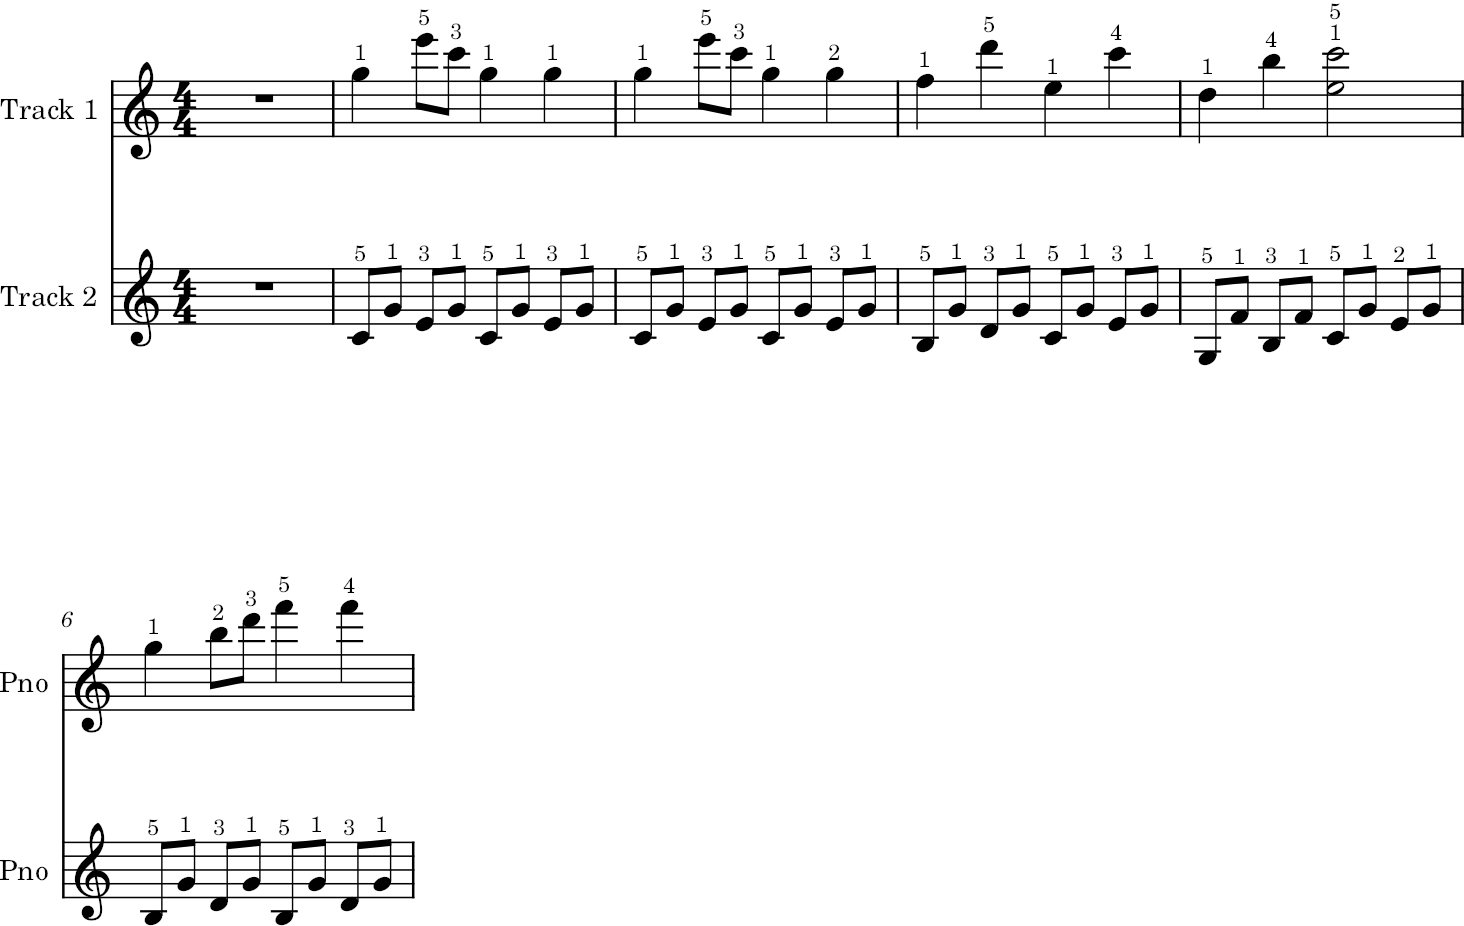

C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

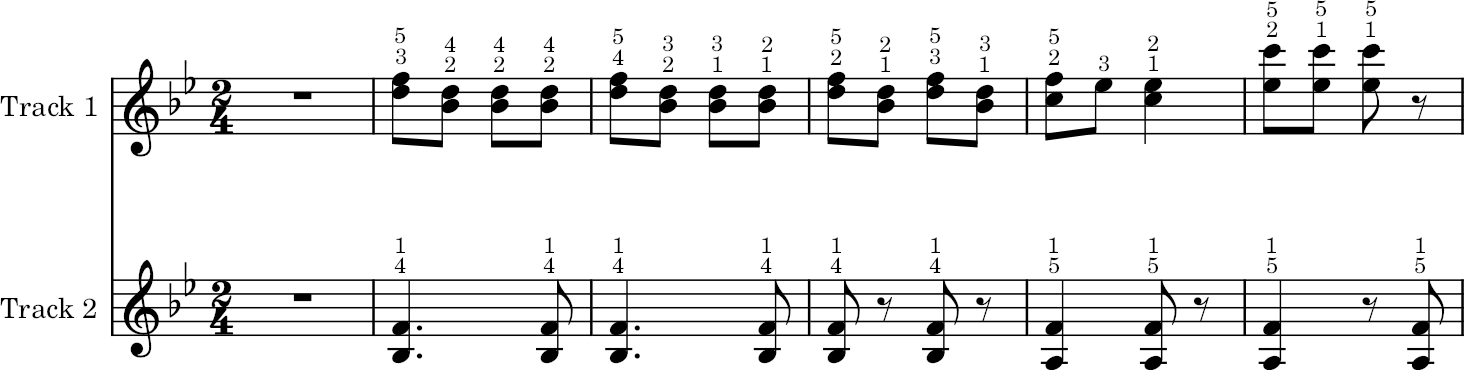

C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

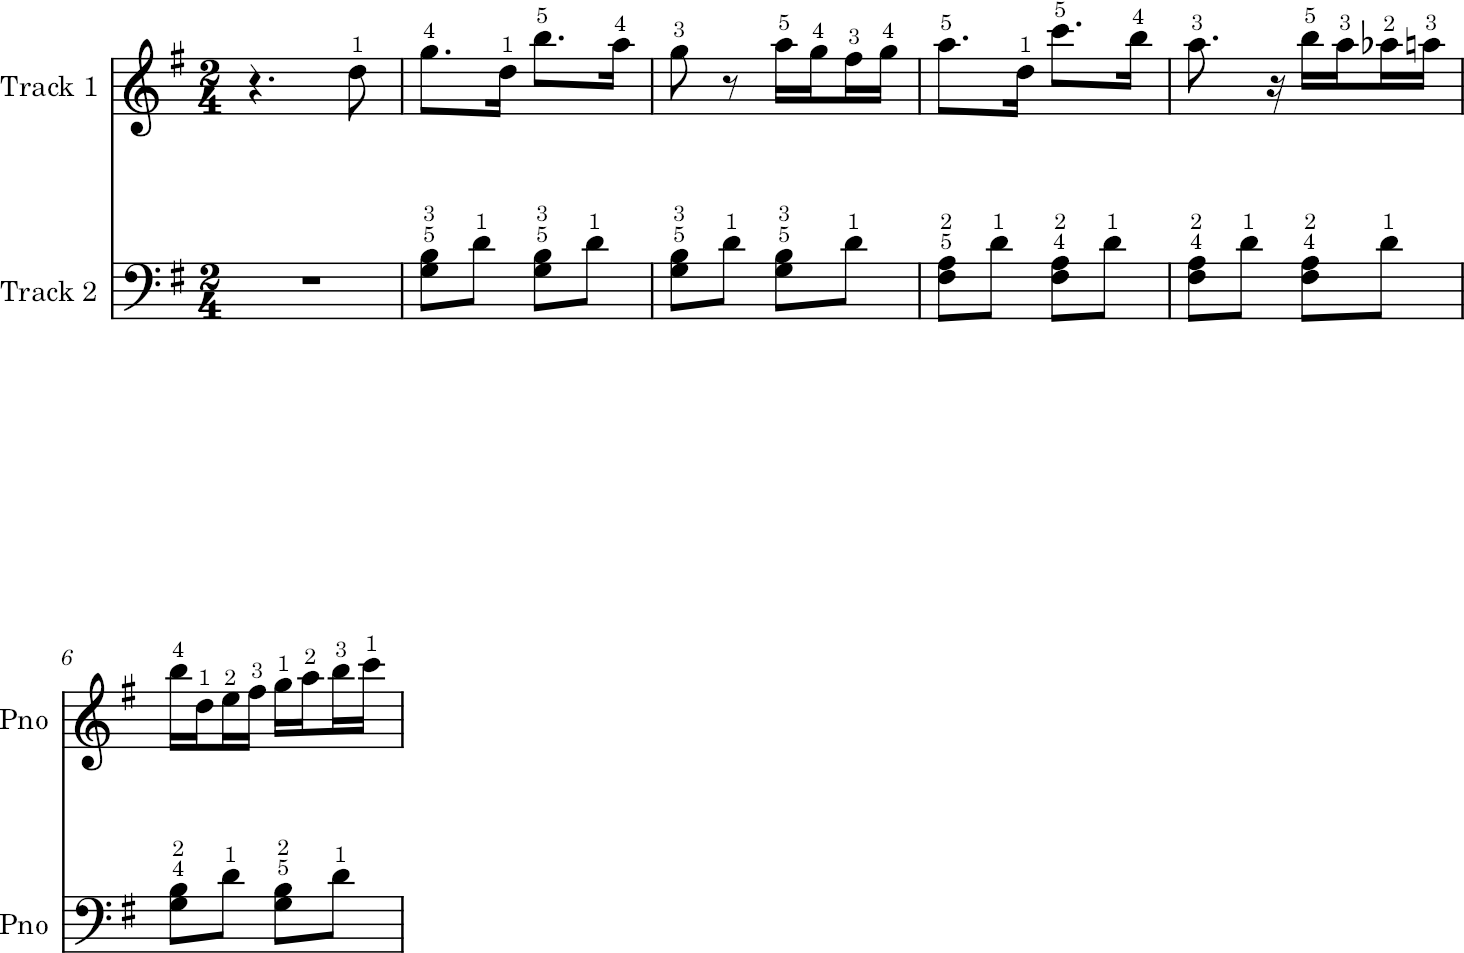

C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

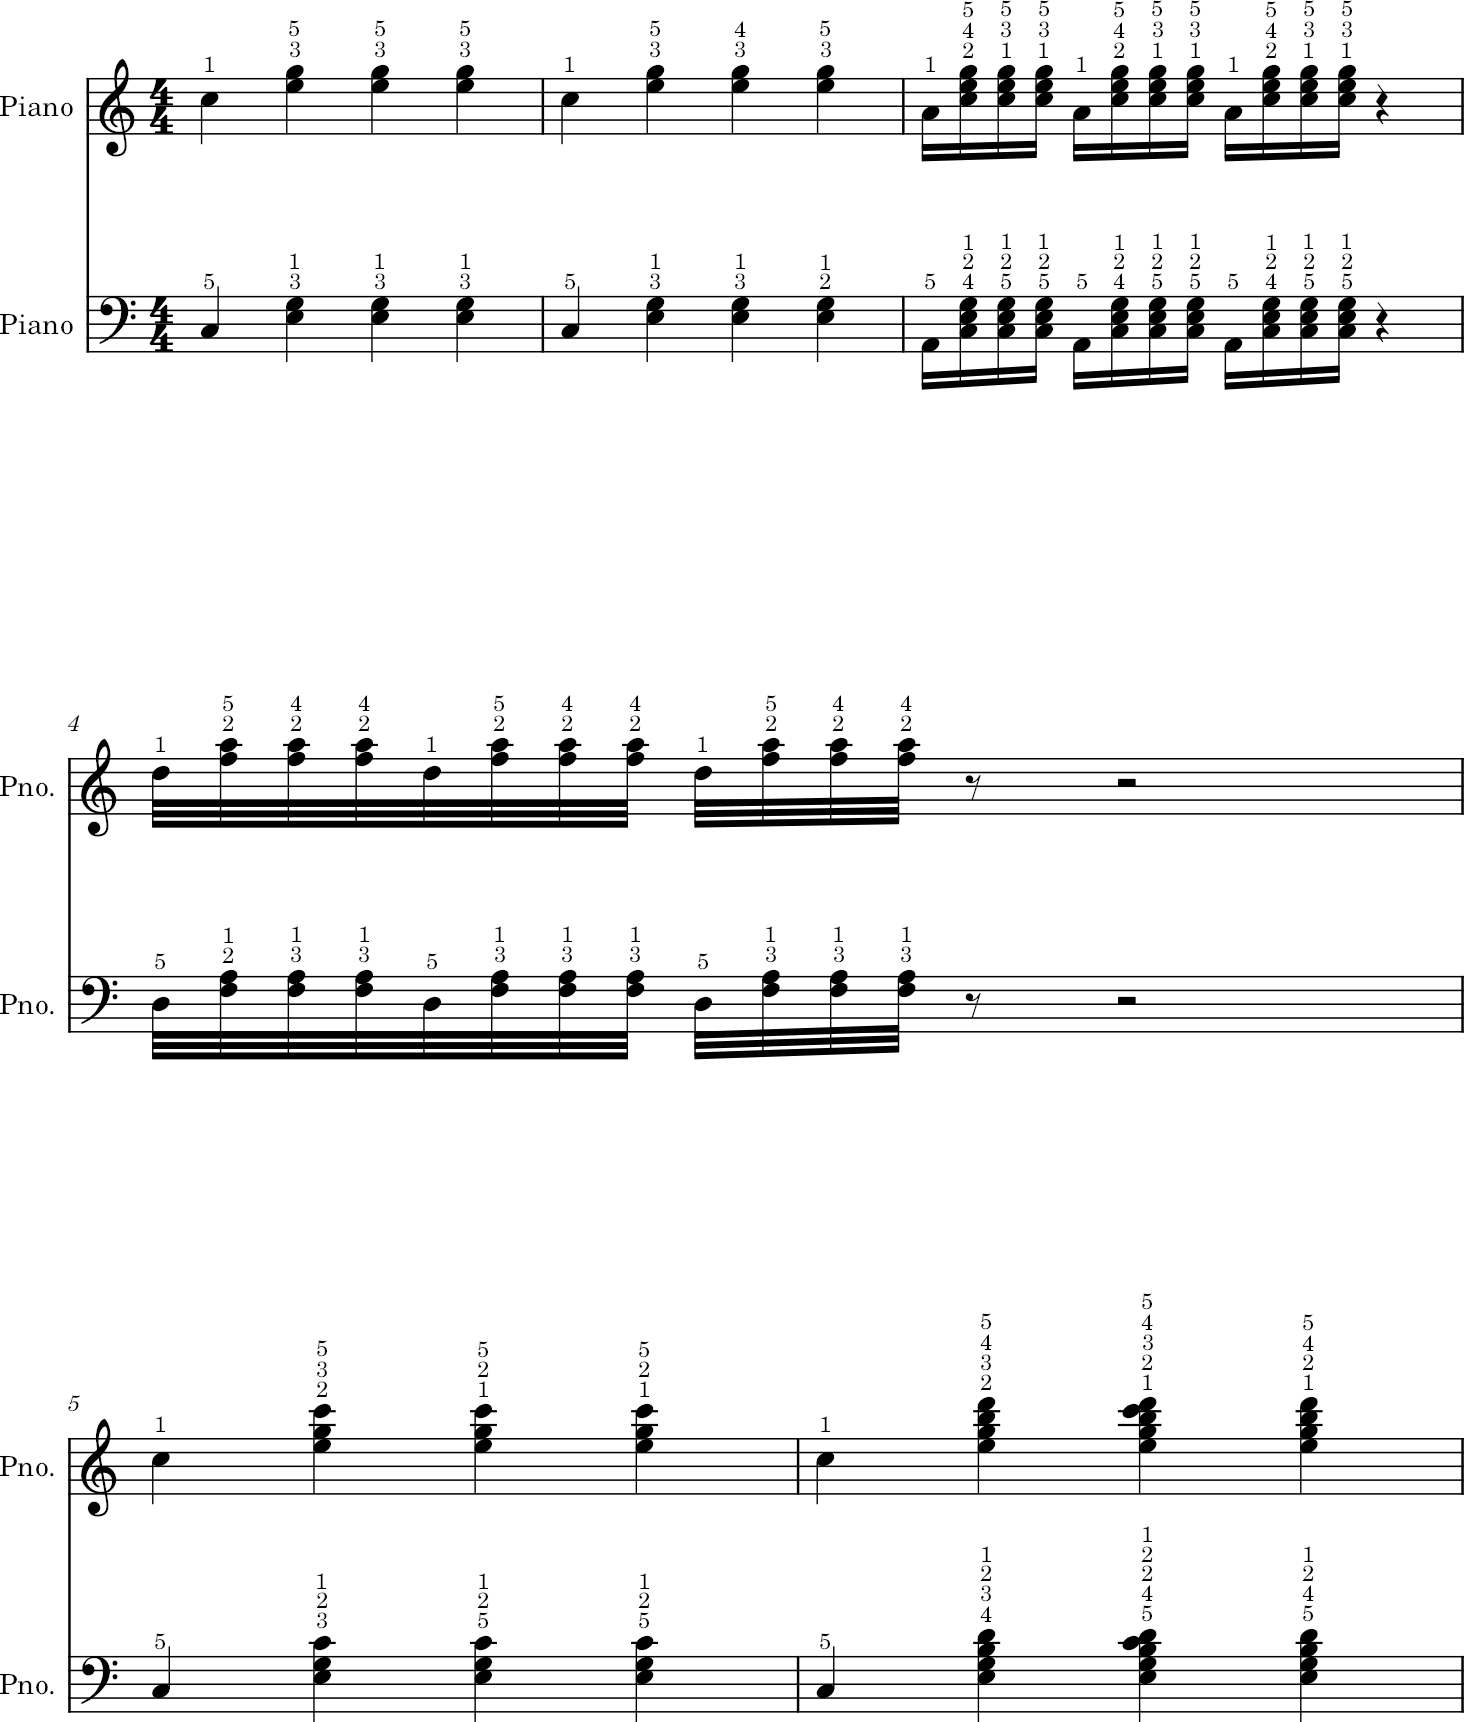

C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

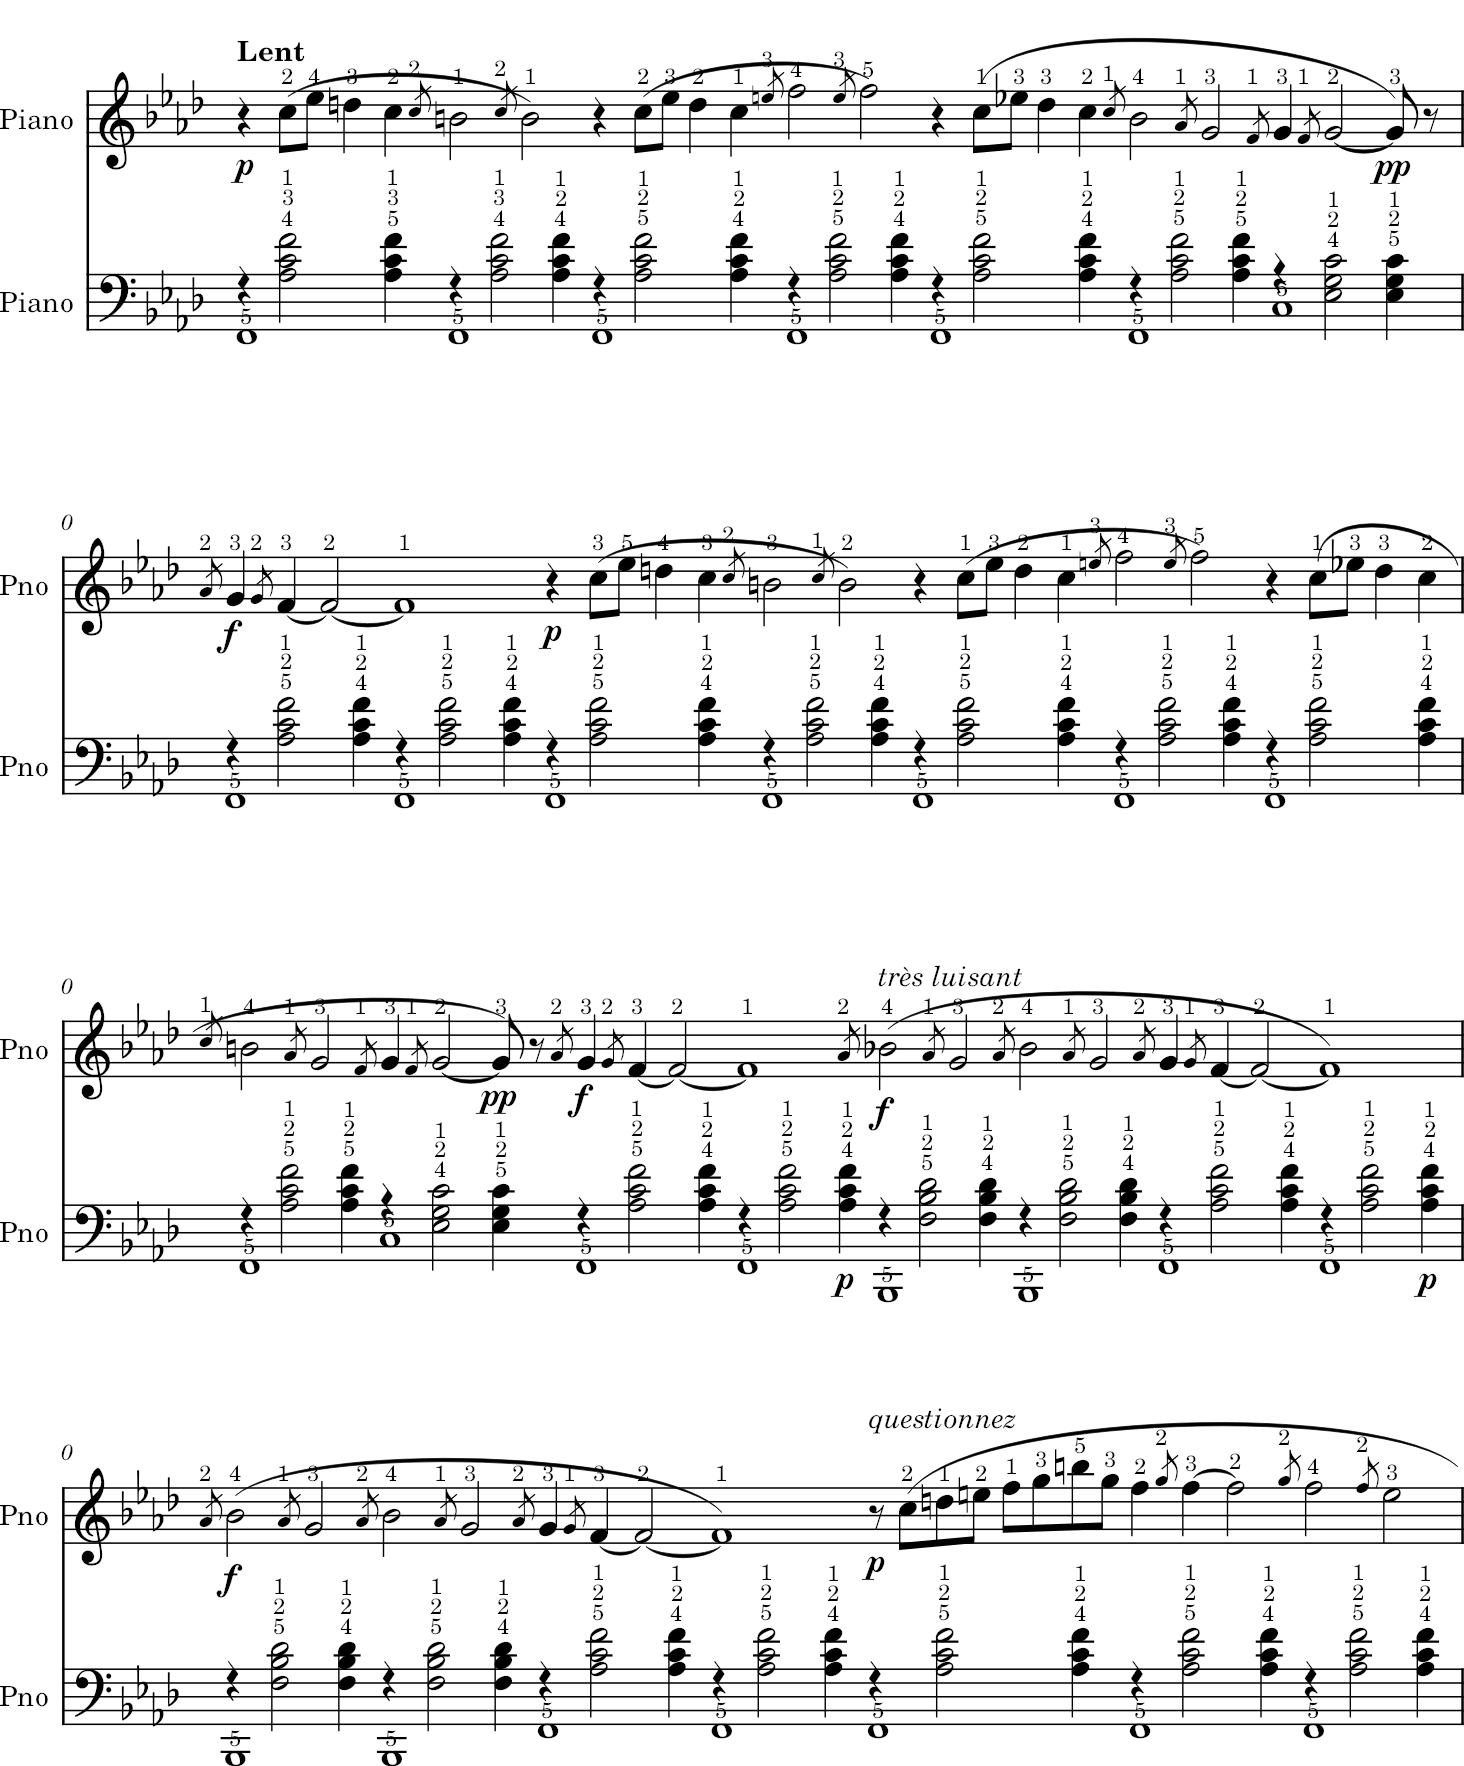

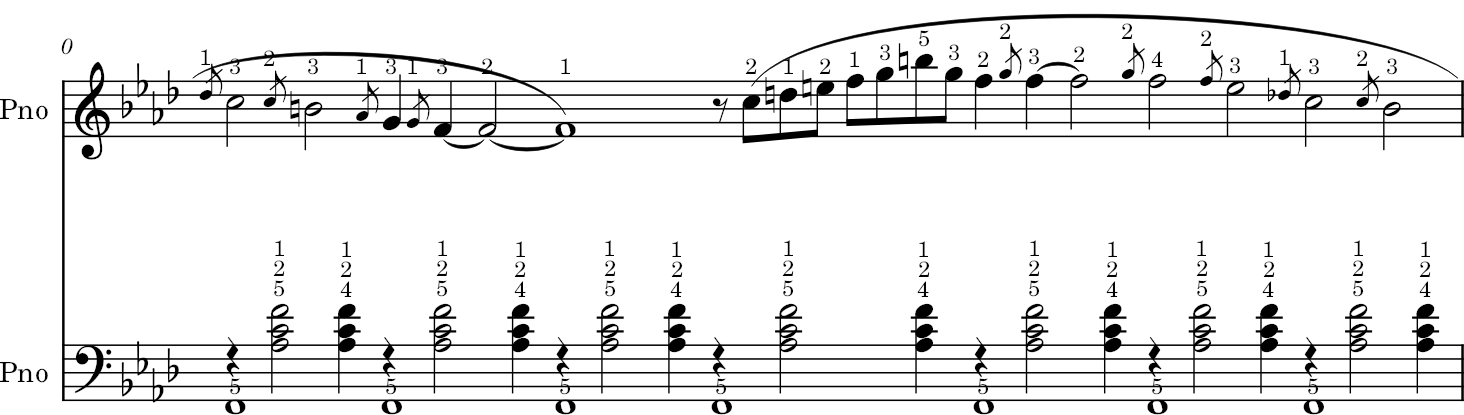

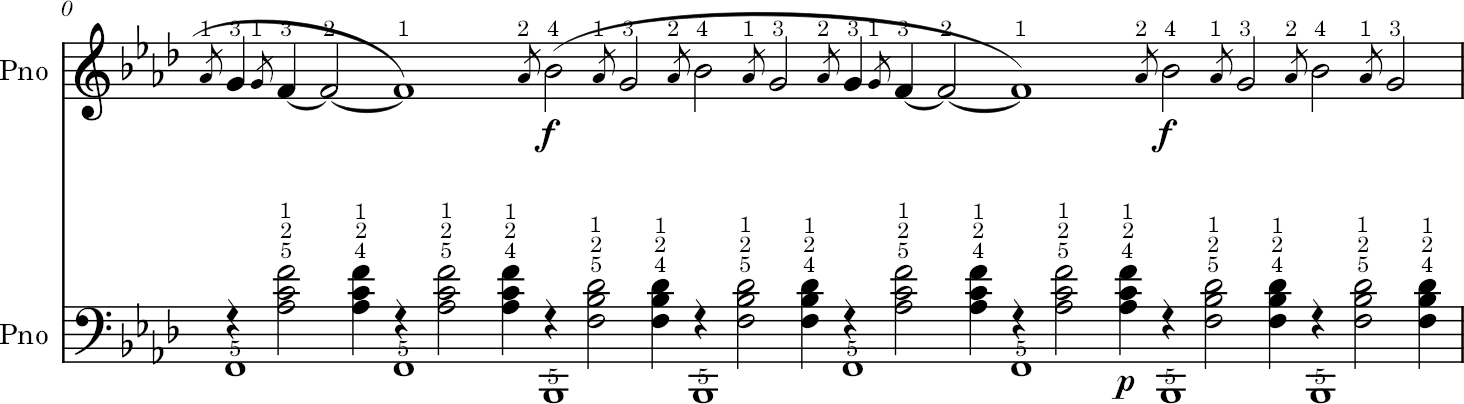

C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
C:\python\Lib\site-packages\music21\stream\base.py:3675: Music21D

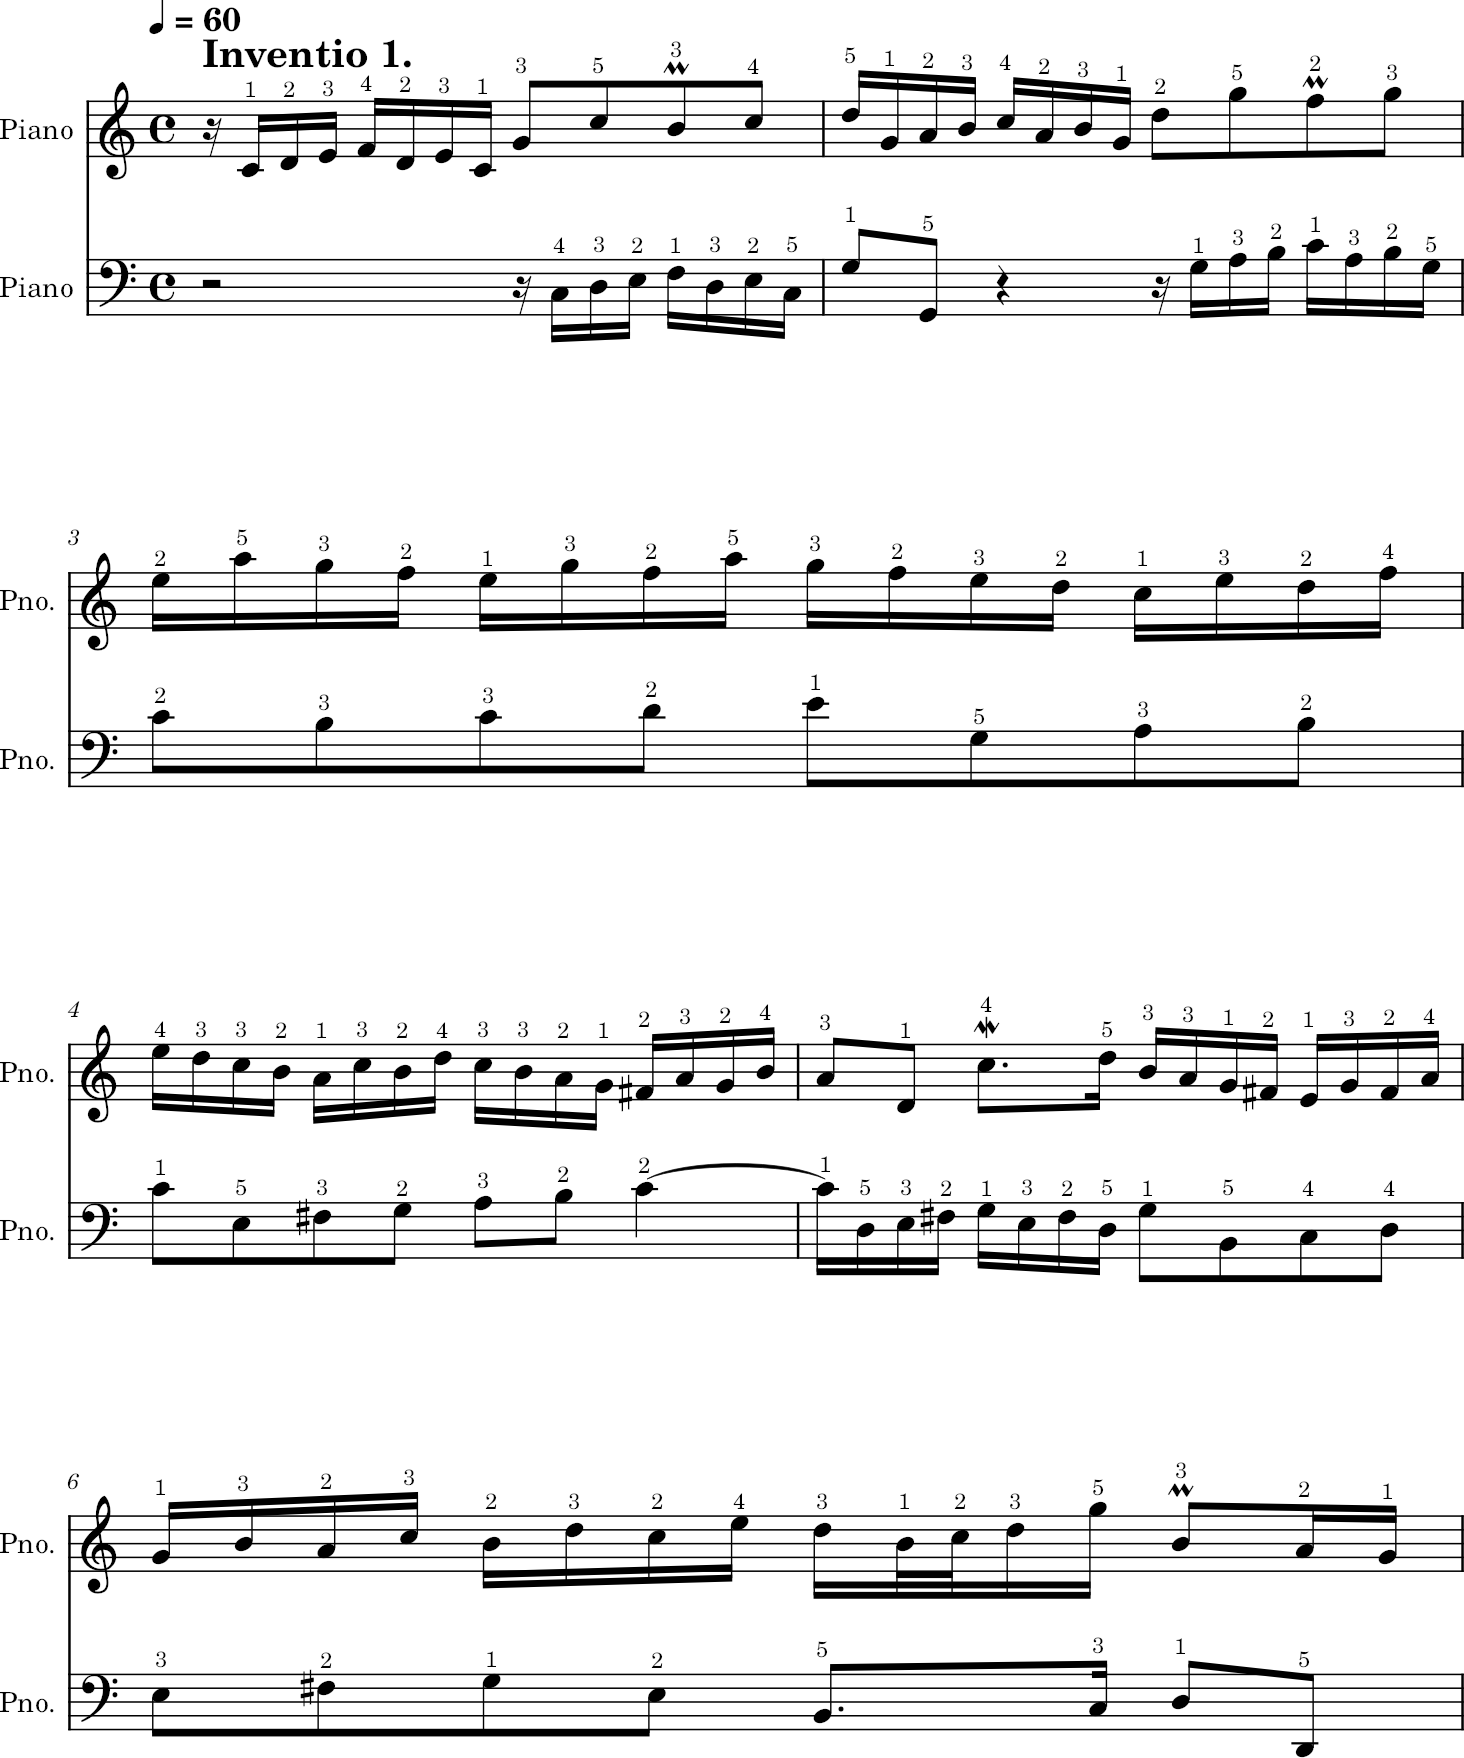

In [46]:
MAIN_DIR = "./"
CSV_DIR = os.path.join(MAIN_DIR, "../data/annotated_csv/")
MXL_DIR = os.path.join(MAIN_DIR, "../data/annotated_mxl/")
os.makedirs(CSV_DIR, exist_ok=True)
os.makedirs(MXL_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dir_data = Path("../models/main/gru/")

all_model_files = list(dir_data.glob("*.pt"))
model_left = next((str(f) for f in all_model_files if "left" in f.name.lower()), None)
model_right = next((str(f) for f in all_model_files if "right" in f.name.lower()), None)

features_path = dir_data / "features_left.txt"
with open(features_path, "r", encoding="utf-8") as f:
    features = [line.strip() for line in f if line.strip()]

test_files = glob.glob("../music_files/*.xml") + glob.glob("../music_files/*.mxl")

annotation_pipeline(
    model_name = "GRU",
    model_right_path = model_right,
    model_left_path = model_left,
    test_files = test_files,
    feature_list = features
)


## Evaluation model on test set

In [27]:
test_candidates = ['../data/pig/040-1_fingering.csv',
 '../data/pig/026-5_fingering.csv',
 '../data/pig/051-1_fingering.csv',
 '../data/pig/030-4_fingering.csv',
 '../data/pig/126-1_fingering.csv',
 '../data/pig/022-3_fingering.csv',
 '../data/pig/041-1_fingering.csv',
 '../data/pig/003-5_fingering.csv',
 '../data/pig/007-1_fingering.csv',
 '../data/pig/047-2_fingering.csv',
 '../data/pig/015-3_fingering.csv',
 '../data/pig/097-1_fingering.csv',
 '../data/pig/038-1_fingering.csv',
 '../data/pig/019-3_fingering.csv',
 '../data/pig/022-1_fingering.csv',
 '../data/pig/141-1_fingering.csv',
 '../data/pig/021-5_fingering.csv',
 '../data/pig/020-3_fingering.csv',
 '../data/pig/117-1_fingering.csv',
 '../data/pig/012-3_fingering.csv',
 '../data/pig/089-1_fingering.csv',
 '../data/pig/064-1_fingering.csv',
 '../data/pig/059-1_fingering.csv',
 '../data/pig/053-1_fingering.csv',
 '../data/pig/122-1_fingering.csv',
 '../data/pig/011-1_fingering.csv',
 '../data/pig/045-2_fingering.csv',
 '../data/pig/046-1_fingering.csv',
 '../data/pig/121-2_fingering.csv',
 '../data/pig/087-1_fingering.csv',
 '../data/pig/076-1_fingering.csv',
 '../data/pig/131-1_fingering.csv',
 '../data/pig/014-1_fingering.csv',
 '../data/pig/011-3_fingering.csv',
 '../data/pig/017-3_fingering.csv',
 '../data/pig/028-4_fingering.csv',
 '../data/pig/001-5_fingering.csv',
 '../data/pig/113-1_fingering.csv',
 '../data/pig/025-3_fingering.csv',
 '../data/pig/032-3_fingering.csv',
 '../data/pig/140-2_fingering.csv',
 '../data/pig/004-8_fingering.csv',
 '../data/pig/026-1_fingering.csv',
 '../data/pig/011-5_fingering.csv',
 '../data/pig/107-1_fingering.csv',
 '../data/pig/001-8_fingering.csv',
 '../data/pig/023-1_fingering.csv']

In [28]:
def evaluate(test_files, model, hand="right", input_features=None):
    total_correct = 0
    total_predictions = 0
    a = None
    
    for file in test_files:
        test_input_list, test_label_list, test_id_list = prepare_test_inputs(file, hand, input_features)
        predicted_fingerings = predict_fingerings(test_input_list, test_label_list, model)
        
        flat_pred = [pred for pred in predicted_fingerings[0]]
        flat_label = [gt for gt in test_label_list[0]]

        correct = sum(p == gt for p, gt in zip(flat_pred, flat_label))
        total_correct += correct
        total_predictions += len(flat_label)
        
        file_accuracy = correct / len(flat_label) if len(flat_label) > 0 else 0
        a = flat_pred

    overall_accuracy = total_correct / total_predictions if total_predictions > 0 else 0
    return a


In [29]:
def get_metrics_for_hand(file_name, hand, verbose=False):
    piece = load_piano_piece(file_name, hand)
    if hand == "right":
        piece[0].fingers = [fin + 1 for fin in piece[0].fingers]
    elif hand == "left":
        piece[0].fingers = [-fin - 1 for fin in piece[0].fingers]
    piano_metirc = PianoMetrics(piece[0], hand=hand, verbose=verbose)
    return piano_metirc.get_metrics_count()


In [30]:
def predict_and_save_fingerings(csv_path, model, device, hand, n, output_path, features=None):
    """Run model prediction on a CSV and save the result."""
    
    predictions = evaluate([csv_path], model, hand, features)

    df = pd.read_csv(csv_path, header=None)
    df.iloc[:, -1]  = df.iloc[:, -1].astype(str).str.split('_').str[0].astype(int)
    if hand == "right":
        df = df[df.iloc[:, -2] == 0]
    else:
         df = df[df.iloc[:, -2] == 1]
        
    df.iloc[:, -1] = df.iloc[:, -1].astype(int)
    df.iloc[n:, -1] = predictions[n:len(df)]

    if hand == "right":
        df.iloc[:, -1] = [fin + 1 for fin in df.iloc[:, -1]]
    else:
        df.iloc[:, -1] = [-fin - 1 for fin in df.iloc[:, -1]]
        df.iloc[:12, -1] = [-fin - 1 for fin in df.iloc[:12, -1]]
        
        
    df.to_csv(output_path, index=False, header=False)
    return output_path


In [35]:
def run_experiment_evaluation(test_candidates, EXP_ROOT, model_type, csv_dir, prediction_start_index=11):
    """
    Run evaluation of all experiments in the given directory.

    Parameters:
        test_candidates (list): List of file paths to test CSV files.
        EXP_ROOT (str): Path to the root directory containing experiment folders.
        model_type (str): Type of model to load (e.g., "GRU", "LSTM").
        csv_dir (str): Directory to save temporary annotated CSVs.
        prediction_start_index (int): Number of initial notes to skip when inserting predictions.

    """
    
    os.makedirs(csv_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def init_metrics():
        return {
            "thumbless_cross": 0,
            "hop": 0,
            "smear": 0,
            "crossed_chord": 0,
            "chord_count": 0,
        }

    def accumulate_metrics(target_dict, source_dict):
        for key, value in source_dict.items():
            target_dict[key] += value

    gt_metrics = init_metrics()
    for file in test_candidates:
        gt_r = get_metrics_for_hand(file, "right", verbose=False)
        gt_l = get_metrics_for_hand(file, "left", verbose=False)
        accumulate_metrics(gt_metrics, gt_r)
        accumulate_metrics(gt_metrics, gt_l)

    all_experiments = sorted(
        [
            d for d in os.listdir(EXP_ROOT)
            if os.path.isdir(os.path.join(EXP_ROOT, d)) and d.startswith("exp")
        ],
        key=lambda x: int(re.search(r'\d+', x).group())
    )

    for exp in all_experiments:
        exp_dir = os.path.join(EXP_ROOT, exp)

        features_path = os.path.join(exp_dir, "features_left.txt")
        with open(features_path, "r") as f:
            features = [line.strip() for line in f if line.strip()]

        right_pt = glob.glob(os.path.join(exp_dir, "*_right.pt"))[0]
        left_pt = glob.glob(os.path.join(exp_dir, "*_left.pt"))[0]
        model_right = load_model(model_type, right_pt, device)
        model_left = load_model(model_type, left_pt, device)

        print(f"\nProcessing {exp} with features: {features}")
        pred_metrics = init_metrics()

        for file in test_candidates:
            print(file)
            file_name = os.path.splitext(os.path.basename(file))[0]
            right_csv = os.path.join(csv_dir, f"{file_name}_right_annotated.csv")
            left_csv = os.path.join(csv_dir, f"{file_name}_left_annotated.csv")

            predict_and_save_fingerings(file, model_right, device, "right", prediction_start_index, right_csv, features[1:])
            predict_and_save_fingerings(file, model_left, device, "left", prediction_start_index, left_csv, features[1:])

            res_r = get_metrics_for_hand(right_csv, "right", verbose=True)
            res_l = get_metrics_for_hand(left_csv, "left", verbose=True)
            accumulate_metrics(pred_metrics, res_r)
            accumulate_metrics(pred_metrics, res_l)

            print("============================\n")

        print("GT metrics: ", gt_metrics)
        print("Predicted metrics: ", pred_metrics)
        print()


In [36]:
run_experiment_evaluation(
    test_candidates=test_candidates,
    EXP_ROOT="../models/gru/attention/hyperparam_search",
    model_type="GRU_Attention",
    csv_dir="../data/annotated_csv/",
    prediction_start_index=11
)

{'input_size': 7, 'hidden_size': 16, 'output_size': 5, 'block_length': 11, 'future_length': 5, 'num_layers': 3}
{'input_size': 7, 'hidden_size': 16, 'output_size': 5, 'block_length': 11, 'future_length': 5, 'num_layers': 3}

Processing exp1_hc16_nl3 with features: ['fingers', 'intervals', 'accidentals_current', 'accidentals_next', 'chord_tonic', 'chord_sixth', 'chord_second_inversion']
../data/pig/040-1_fingering.csv

../data/pig/026-5_fingering.csv
HOP: prev 58.0 (onset 15.94, offset 16.04), cur 59.0 (onset 16.04 offset 16.15), fingers: 1 → 1
HOP: prev 58.0 (onset 17.81, offset 17.92), cur 59.0 (onset 17.92 offset 18.02), fingers: 1 → 1

Crossed fingers in chord at onset=7.5, offset=7.81:
Note	 Finger	 Onset	 Offset
73.0	 5	 7.5	 7.81
77.0	 2	 7.5	 7.81
85.0	 5	 7.5	 7.81

Crossed fingers in chord at onset=22.5, offset=22.81:
Note	 Finger	 Onset	 Offset
73.0	 2	 22.5	 22.81
75.0	 1	 22.5	 22.81
79.0	 2	 22.5	 22.81
82.0	 3	 22.5	 22.81
87.0	 5	 22.5	 22.81
thumbless_crosses: prev 64.0